In [41]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Generate batches of tensor image data with real-time data augmentation.
from tensorflow.keras.applications import MobileNetV2 # CNN architecture that works well w/mobile devices as well
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Preprocesses a tensor or Numpy array encoding a batch of images.
from tensorflow.keras.preprocessing.image import img_to_array, load_img 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical # converts a class vector (integers) to a binary class matrix
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from imutils import paths
import cv2
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgrey'

In [42]:
init_lr = 1e-4
epochs = 200
bs = 32
image_size = (224,224)

CATEGORIES = ["with_mask","without_mask"]

In [43]:
print("[INFO] loading images...")


[INFO] loading images...


In [45]:
# MobileNetV2 CNN architecture model
def build_model(num_classes, img_size=224):
    # load MobileNetV2 network, ensuring the head FC (Fully Connected) layer sets are left off
    inputs = Input(shape=(img_size,img_size,3))    
    baseModel = MobileNetV2(input_shape=(img_size,img_size,3),weights="imagenet", include_top=False, input_tensor=inputs)
    
    
    # create the head of the model that will be placed on top of the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    
    headModel = Dense(num_classes, activation="softmax")(headModel)
    
    # place the head FC model on top of the base model (this will become the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

    # lopp over all layers in the base model and freeze them so they will not be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable=False
        
    # compile model
    print("[INFO] compiling model...")
    opt = Adam(lr=init_lr,decay=init_lr / epochs)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [26]:
# Pipeline for image augmentation
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2)

In [27]:
train = datagen.flow_from_directory('data',classes=['with_mask','without_mask'],target_size=image_size, batch_size=bs,seed=42,subset='training')
test = datagen.flow_from_directory('data',classes=['with_mask','without_mask'],target_size=image_size, batch_size=bs,seed=42,subset='validation')

x_train, y_train = next(train)
x_test,y_test = next(test)

Found 4792 images belonging to 2 classes.
Found 1197 images belonging to 2 classes.


In [28]:
num_classes = len(CATEGORIES)
model = build_model(num_classes)

# train head of the network
print("[INFO] training head...")
H = model.fit(
        x_train,
        y_train,
        steps_per_epoch=(len(x_train) // bs),
        validation_data=(x_test,y_test),
        validation_steps=len(x_test) // bs,
        batch_size=bs,
        epochs=epochs,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  verbose=1,
                                                  patience=6,
                                                  restore_best_weights=True)
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/200


/home/atlas/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


1/1 [==============================] - 3s 3s/step - loss: 1.2428 - accuracy: 0.4375 - val_loss: 0.7047 - val_accuracy: 0.4688
Epoch 2/200
1/1 [==============================] - 1s 793ms/step - loss: 1.2599 - accuracy: 0.4062 - val_loss: 0.6939 - val_accuracy: 0.5625
Epoch 3/200
1/1 [==============================] - 1s 788ms/step - loss: 1.1251 - accuracy: 0.3438 - val_loss: 0.6854 - val_accuracy: 0.5938
Epoch 4/200
1/1 [==============================] - 1s 788ms/step - loss: 0.8312 - accuracy: 0.7188 - val_loss: 0.6783 - val_accuracy: 0.5938
Epoch 5/200
1/1 [==============================] - 1s 799ms/step - loss: 1.0196 - accuracy: 0.4062 - val_loss: 0.6727 - val_accuracy: 0.5938
Epoch 6/200
1/1 [==============================] - 1s 900ms/step - loss: 1.1484 - accuracy: 0.5938 - val_loss: 0.6685 - val_accuracy: 0.5938
Epoch 7/200
1/1 [==============================] - 1s 790ms/step - loss: 1.0001 - accuracy: 0.5625 - val_loss: 0.6651 - val_accuracy: 0.6250
Epoch 8/200
1/1 [===========

KeyboardInterrupt: 

In [29]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=bs)

# for each img in the testing set, we need to find idx of label w/corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...


In [30]:
print(classification_report(np.argmax(y_test, axis=1), predIdxs, target_names=['Mask','No Mask']))

              precision    recall  f1-score   support

        Mask       0.80      0.80      0.80        15
     No Mask       0.82      0.82      0.82        17

    accuracy                           0.81        32
   macro avg       0.81      0.81      0.81        32
weighted avg       0.81      0.81      0.81        32



In [32]:
# serialize the model to disk
print('[INFO] saving mask detector model...')
model.save("detect_mask.model", save_format='h5')

[INFO] saving mask detector model...


AxesSubplot(0.125,0.125;0.62x0.755)


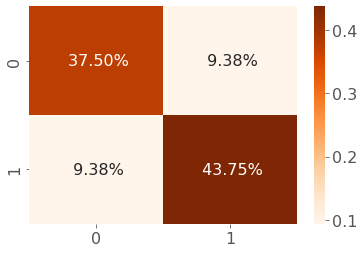

In [33]:
# Confusion Matrix
cf_matrix = confusion_matrix(np.argmax(y_test,axis=1), predIdxs)
cm = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Oranges', fmt= ' .2%');
print(cm)

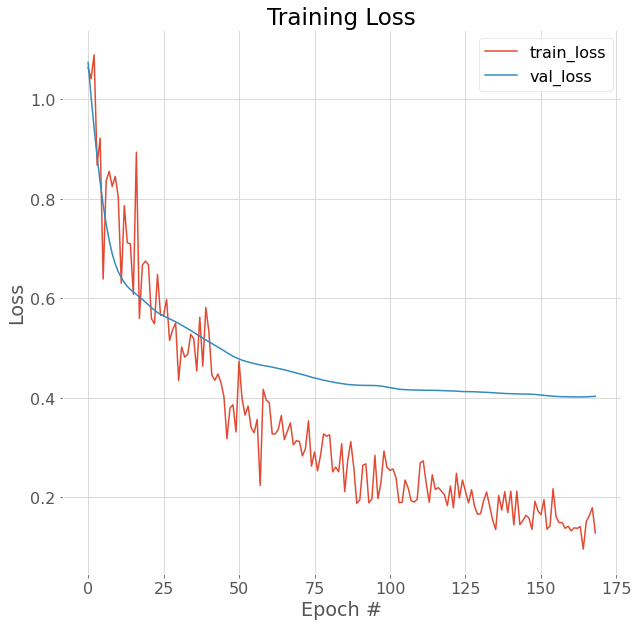

In [34]:
# plot the training loss
plt.figure(figsize=(10,10))
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['val_loss'], label='val_loss')
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.savefig("images/train_loss.png")

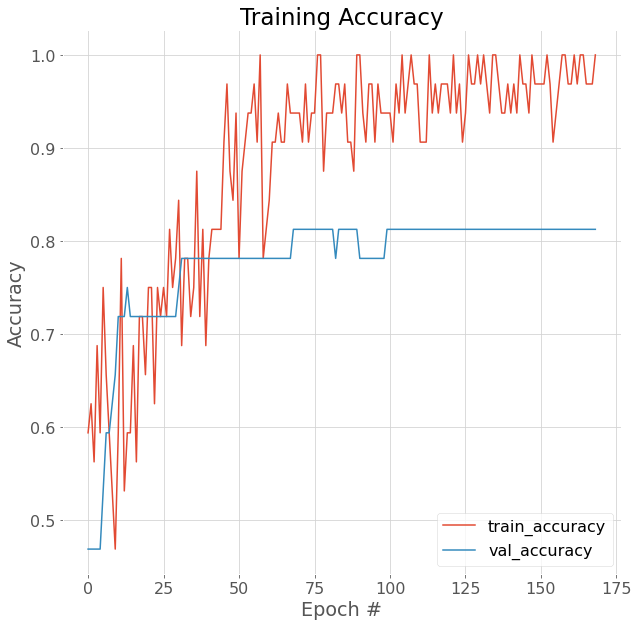

In [35]:
#plot the training accuracy
plt.figure(figsize=(10,10))
plt.plot(H.history['accuracy'], label='train_accuracy')
plt.plot(H.history['val_accuracy'], label='val_accuracy')
plt.title('Training Accuracy')
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.savefig("images/train_accuracy.png")